In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community  #instalujemy potrzebne biblioteki

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.74
    Uninstalling langchain-core-0.3.74:
      Successfully uninstalled langchain-core-0.3.74
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
g

In [3]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA

# MOŻESZ IMPORTOWAĆ INNE BIBLIOTEKI, ALE PAMIĘTAJ O ICH INSTALACJI W WIERSZU POWYŻEJ !!!

# Asystent AI - PDF RAG
Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

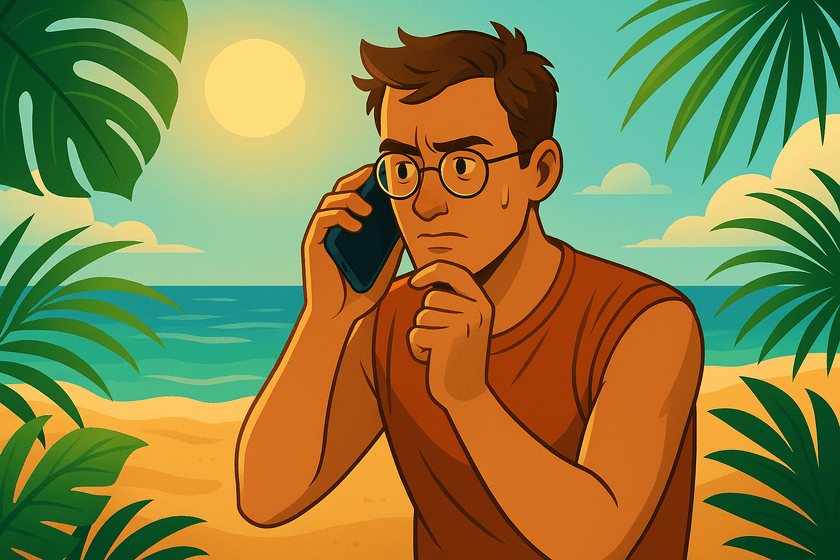

(*AI-generated image*)

### Zadanie
Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).
### Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

### Wymagania
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






Dla zadania znajdowałem 4 artykuły naukowe na temat jogurtu, bo jogurt jest najlepszym tematem dla pracy jeżeli nie wiesz co wybrać. Zacznimy od przygotowania artykułów, kod z lekcji został troche zmodyfikowany żeby załadować i przetworzyć kilka dokumentów

In [81]:
# Zacznij kodować ...
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List

def process_docs(file_paths: List[str]):
  all_docs = []
  text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=300,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
  )

  for file in file_paths:
    loader = PyPDFLoader(file)
    pages = loader.load()
    docs = text_splitter.split_documents(pages)

    all_docs.extend(docs)

  return all_docs

yogurts = [
    "/content/drive/MyDrive/ml/yogurt1.pdf",
    "/content/drive/MyDrive/ml/yogurt2.pdf",
    "/content/drive/MyDrive/ml/yogurt3.pdf",
    "/content/drive/MyDrive/ml/yogurt4.pdf",
]

docs = process_docs(yogurts)

for idx, doc in enumerate(docs):
    print(f"[{idx}]. {doc}\n\n")

[0]. page_content='Citation: Hadjimbei, E.; Botsaris, G.;
Chrysostomou, S. Beneﬁcial Effects of
Yoghurts and Probiotic Fermented
Milks and Their Functional Food
Potential. Foods 2022, 11, 2691.
https://doi.org/10.3390/
foods11172691
Academic Editors: Juristo Fonollá
and Sandra González-Palacios
Received: 16 June 2022
Accepted: 1 September 2022
Published: 3 September 2022
Publisher’s Note:MDPI stays neutral
with regard to jurisdictional claims in
published maps and institutional afﬁl-
iations.' metadata={'producer': 'pdfTeX-1.40.21', 'creator': 'LaTeX with hyperref', 'creationdate': '2022-09-03T17:53:16+08:00', 'author': 'Elena Hadjimbei, George Botsaris and Stavrie Chrysostomou', 'keywords': 'yoghurt; fermented milk; probiotics; health benefits; functional food', 'moddate': '2022-09-03T12:02:56+02:00', 'subject': 'Probiotic fermented milks and yoghurts are acidified and fermented by viable bacteria, usually L. bulgaricus and S. thermophilus, resulting in a thicker product with a longer

Wybrano było embedding sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2, bo miał on na stronie 10.5M w Downloads

In [82]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Model embeddings z Hugging Face
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Tworzenie i zapis bazy FAISS
db = FAISS.from_documents(docs, embeddings)
db.save_local("faiss_index_hf")

Przechodząc do modeli. Minimalnym progiem żeby zaliczyć odpowiedz jako poprawną wybrano 0.2, nawet na tym poziomie dają się głupote ale niżej już są absurdalne. Kod był troche zmodyfikowany z lekcji: dodano pętle dla chatu i przekazanie parametrów dla cytowania dokumentów. Nie potrafiłem dodać pamięci do chatu. QA model wybrano roberta

In [83]:
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering

model_name = "deepset/roberta-base-squad2-distilled"
qa_pipeline = pipeline(
    "question-answering",
    model=AutoModelForQuestionAnswering.from_pretrained(model_name),
    tokenizer=AutoTokenizer.from_pretrained(model_name)
)

MIN_ANSWER_SCORE = 0.20

while True:
  query = input("Question:")
  if query.lower() in ["exit", "end", "quite"]:
    print("Goodbye fellow yogurt enjoyer!")
    break

  retrieved_docs = db.similarity_search(query, k=4)

  best = None

  for d in retrieved_docs:
    ans = qa_pipeline(question=query, context=d.page_content)

    src = d.metadata.get("source", "unknown_source")
    page = d.metadata.get("page", "unknown_page")

    candidate = {
        "answer": ans.get("answer", "").strip(),
        "score": float(ans.get("score", 0.0)),
        "source": src,
        "page": page,
        "context": d.page_content[:400].replace("\n", " ") + ("..." if len(d.page_content) > 400 else "")
    }

    if best is None or candidate["score"] > best["score"]:
            best = candidate

  if not best or best["score"] < MIN_ANSWER_SCORE or best["answer"] in {"", " ", "[CLS]"}:
      print("Try rephrasing or asking about a different aspect.\n")
      continue

  print(f"🤖 Answer: {best['answer']} (confidence={best['score']:.3f})")
  print(f"   Source: {best['source']}  |  page: {best['page']}\n")
  print(f"   Context: {best['context']}")


Device set to use cpu


Question:What basic nutrients are in yogurt?
🤖 Answer: Vitamin D, calcium, and protein (confidence=0.973)
   Source: /content/drive/MyDrive/ml/yogurt2.pdf  |  page: 10

   Context: (Salama et al., 2022). Fortified Yogurt Fortified yogurt aims to compensate for nutrient de- ficiencies or enhance specific nutrients, making it more  beneficial for preventing or treating diseases without  compromising quality or customer acceptability (Bashir  Mir et al., 2021). Vitamin D, calcium, and protein are  essential for bone health, and although yogurt is a good  source of calcium and p...
Question:What protein yogurt contains?
🤖 Answer: bioactive proteins (confidence=0.617)
   Source: /content/drive/MyDrive/ml/yogurt2.pdf  |  page: 1

   Context: 34 Journal of Dairy Science Vol. 108 No. 1, 2025 ence for the dairy industry and researchers dedicated to  the advancement of yogurt development. Key words: protein sources, safety and quality,  functionality, sensory evaluation, consumer perceptions INT

## Tajemniczy zleceniodawca

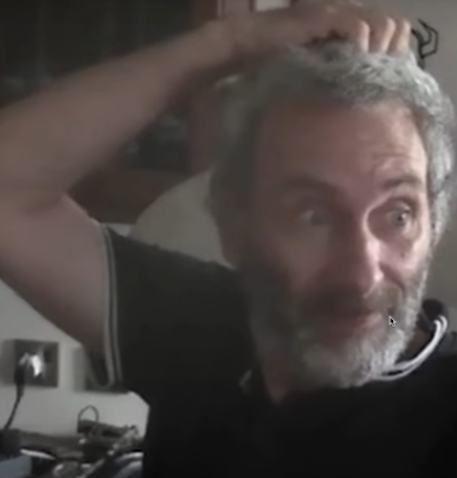